## Generating surface plots for ICC differences and parcel-wise gradient flow vectors:
 * Mean of ICC differences and mean gradient flow vector direction for each parcel connectivity vector (row/column of ICC/gradient flow matrix) are plotted on the cortical surface with **BrainSpace** .
 * **calc_icc_vectors** first calculates standardized gradient flow vectors using the parcel vector mean of inter- and intra-individual differences to yield mean gradient flow vector direction for each parcel.
     * Separate surface plots are generated for positive and negative ICC difference and gradient flow direction for clarity.
     * Due to averaging across the parcel connectivity vector, ICC difference and gradient flow direction might not have complete congruency. 

1. We first set up the data by filling in a 360 x 360 matrix with our array of edges.
2. We then take the mean of each row (mean of inter-individual and intra-individual variations and icc for each parcel)
3. After calculating the **mean** gradient flow vectors, we use a parcel-to-vertex label file to map gradient flow vectors for each parcel onto a 10k per hemisphere vertex cortical surface


In [1]:
%matplotlib inline
import sys
import numpy as np
sys.path.append('../reliability')

# Load Data:
data = np.load('../tutorial/example_data/tutorial_data.npy',allow_pickle=True).item()
tasks = [task for task in data.keys()]

print('Task conditions in data variable: %s' % tasks)
print('Dictionary keys within each task condition: %s' % [data_keys for data_keys in data[tasks[0]].keys()])

Task conditions in data variable: ['REST_nogsr', 'REST_gsr']
Dictionary keys within each task condition: ['rawb', 'raww', 'icc', 'vartotal', 'totmask']


In [20]:
# BrainSpace functions needed:
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface

from gradient_flow_vectors import calc_icc_vectors,pah
from variability_utils import array2mat,parcel2vert,glasserlabel,gradientFlowCmaps # Convert array of parcellated data to array of surface vertex data

numParcels = 360 # Number of Glasser 2016 parcels

# Fill matrix and take row mean:
parcdf = {}
measures = ['icc','raww','rawb']
for task in tasks:
    parcdf[task] = {}
    for m in measures:
        parcdf[task][m] = np.nanmean(array2mat(data[task][m],numParcels),0)

# Calculate parcel mean gradient flow vectors:
df = calc_icc_vectors(parcdf[tasks[0]]['raww'],parcdf[tasks[0]]['rawb'],parcdf[tasks[0]]['icc'],
                      parcdf[tasks[1]]['raww'],parcdf[tasks[1]]['rawb'],parcdf[tasks[1]]['icc'],
                      tasks[0],tasks[1])

# Generate 20k vertex array from parcellation:
angVerts = parcel2vert(glasserlabel,df['theta0'])

# Create mask and remove medial wall/subcortical regions:
parcellation_mask = np.where(glasserlabel[0,:] == 0)[0]
angVerts[0,parcellation_mask] = np.nan

# Load Conte 10k surface
lsurf = read_surface('../reliability/misc/surfaces/Conte69.L.very_inflated.10k_fs_LR.surf.gii')
rsurf = read_surface('../reliability/misc/surfaces/Conte69.R.very_inflated.10k_fs_LR.surf.gii')


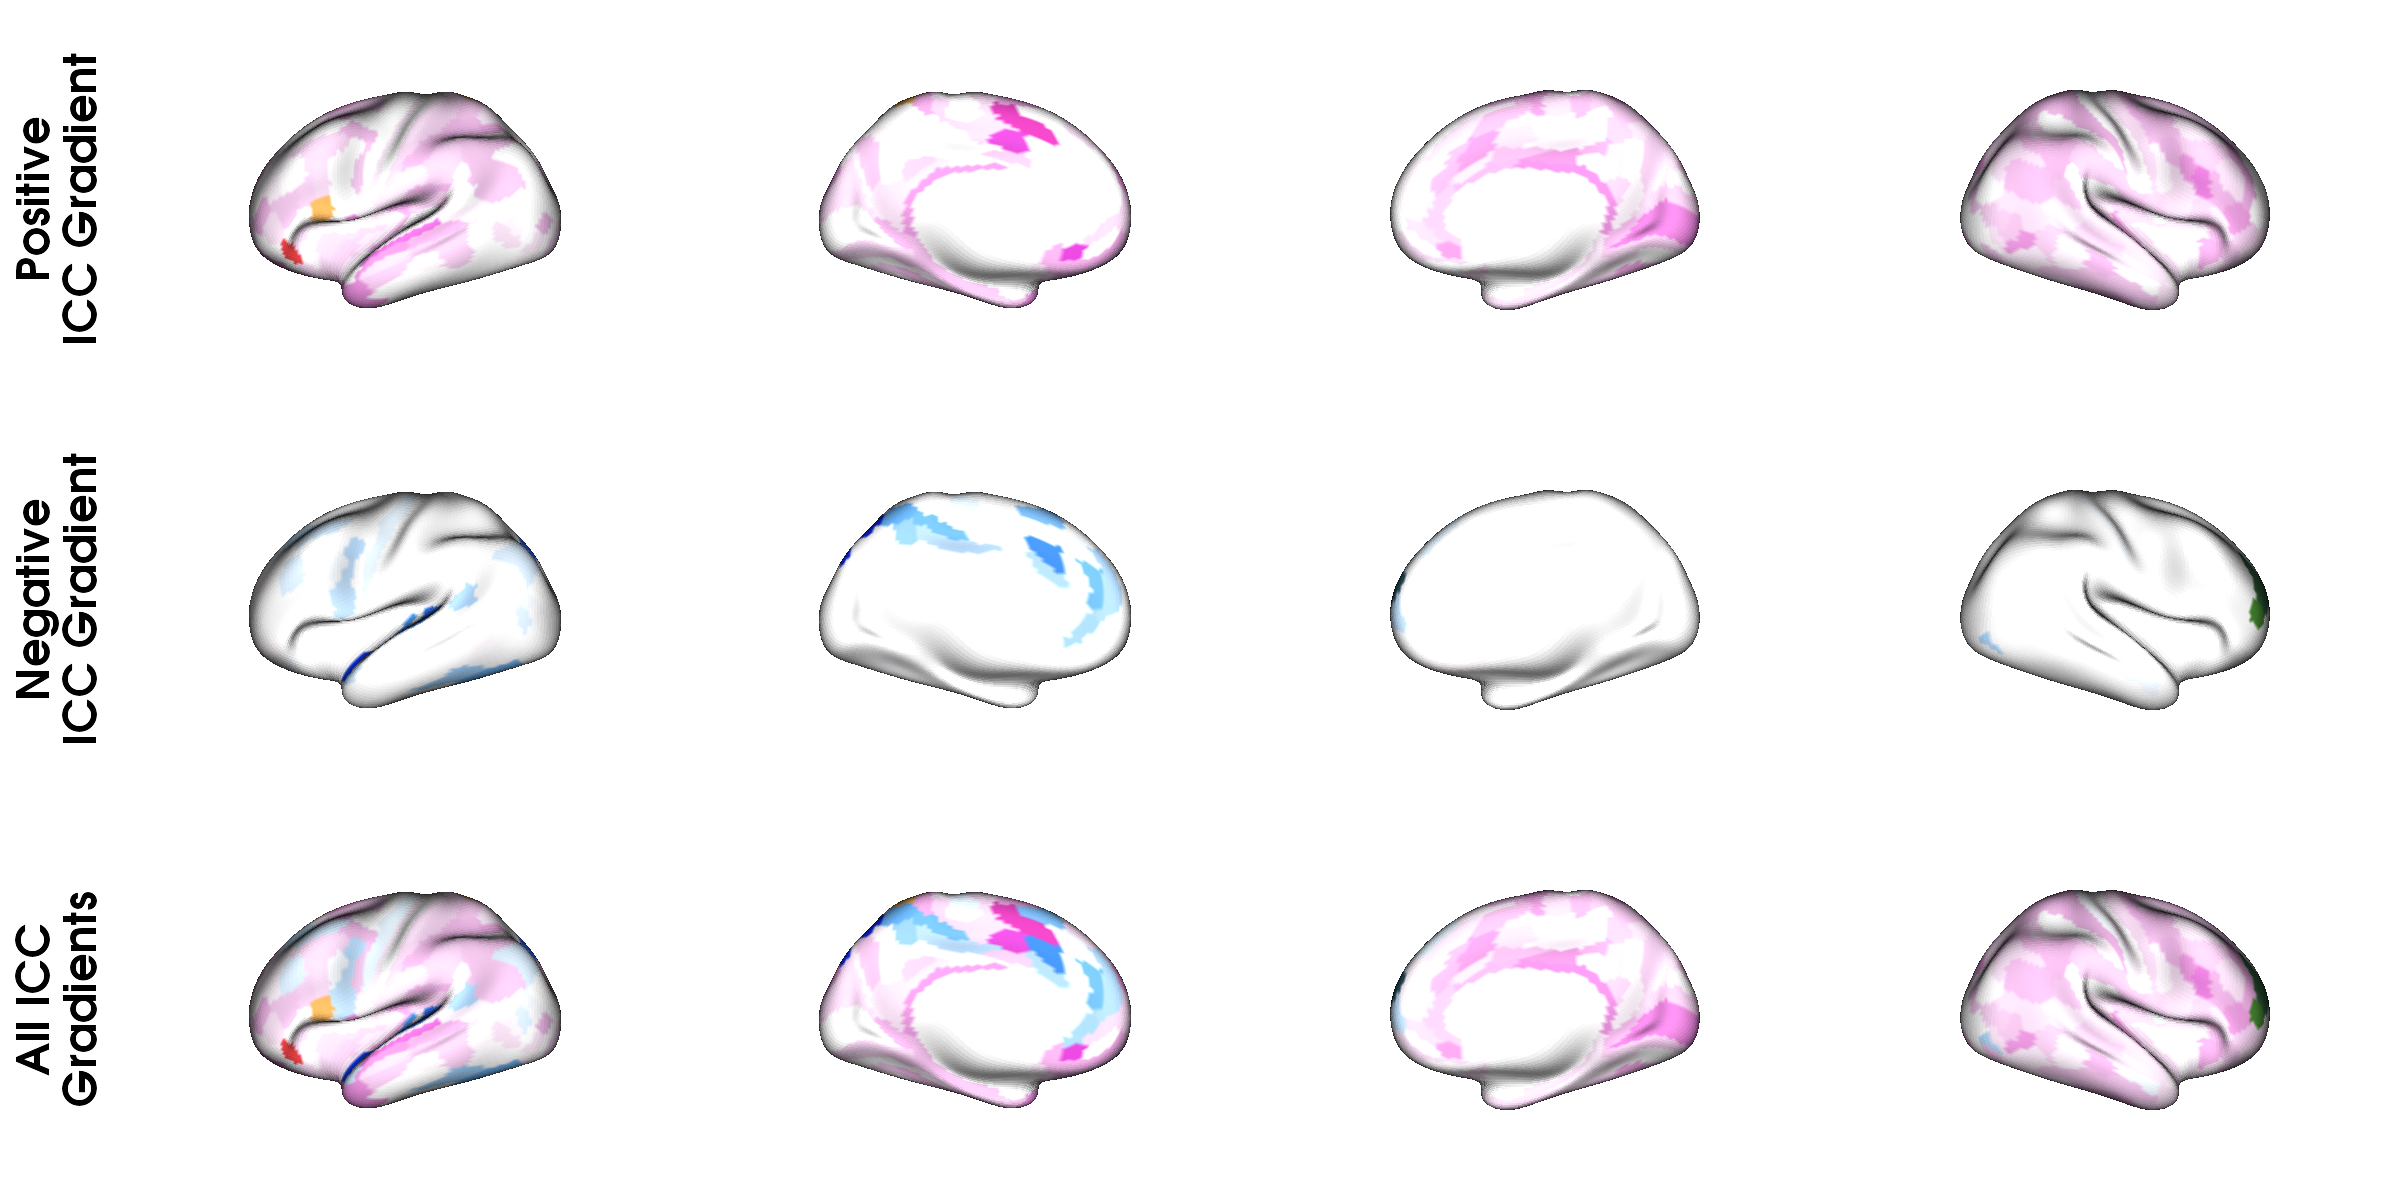

In [21]:
vertArrays = [angVerts[0,:]]*3
plot_hemispheres(lsurf, rsurf, array_name=vertArrays, size=(2400, 1200), 
                 cmap=[gradientFlowCmaps['warm'],gradientFlowCmaps['cold'],gradientFlowCmaps['complete']],
                color_bar=False,interactive=False,embed_nb=True,nan_color=(1,1,1,1),color_range=(0,360),
                 label_text=['Positive\nICC Gradient','Negative\nICC Gradient','All ICC\nGradients'],
                mapper__interpolateScalarsBeforeMapping=False)


While data processed without GSR has overall greater reliability compared to data processed with GSR, we can see topological differences in different brain regions as shown by surface plots showing ICC differences as well as gradient vectors. With this information different preprocessing steps can be applied when higher reliability is desired for the target region being studied. 

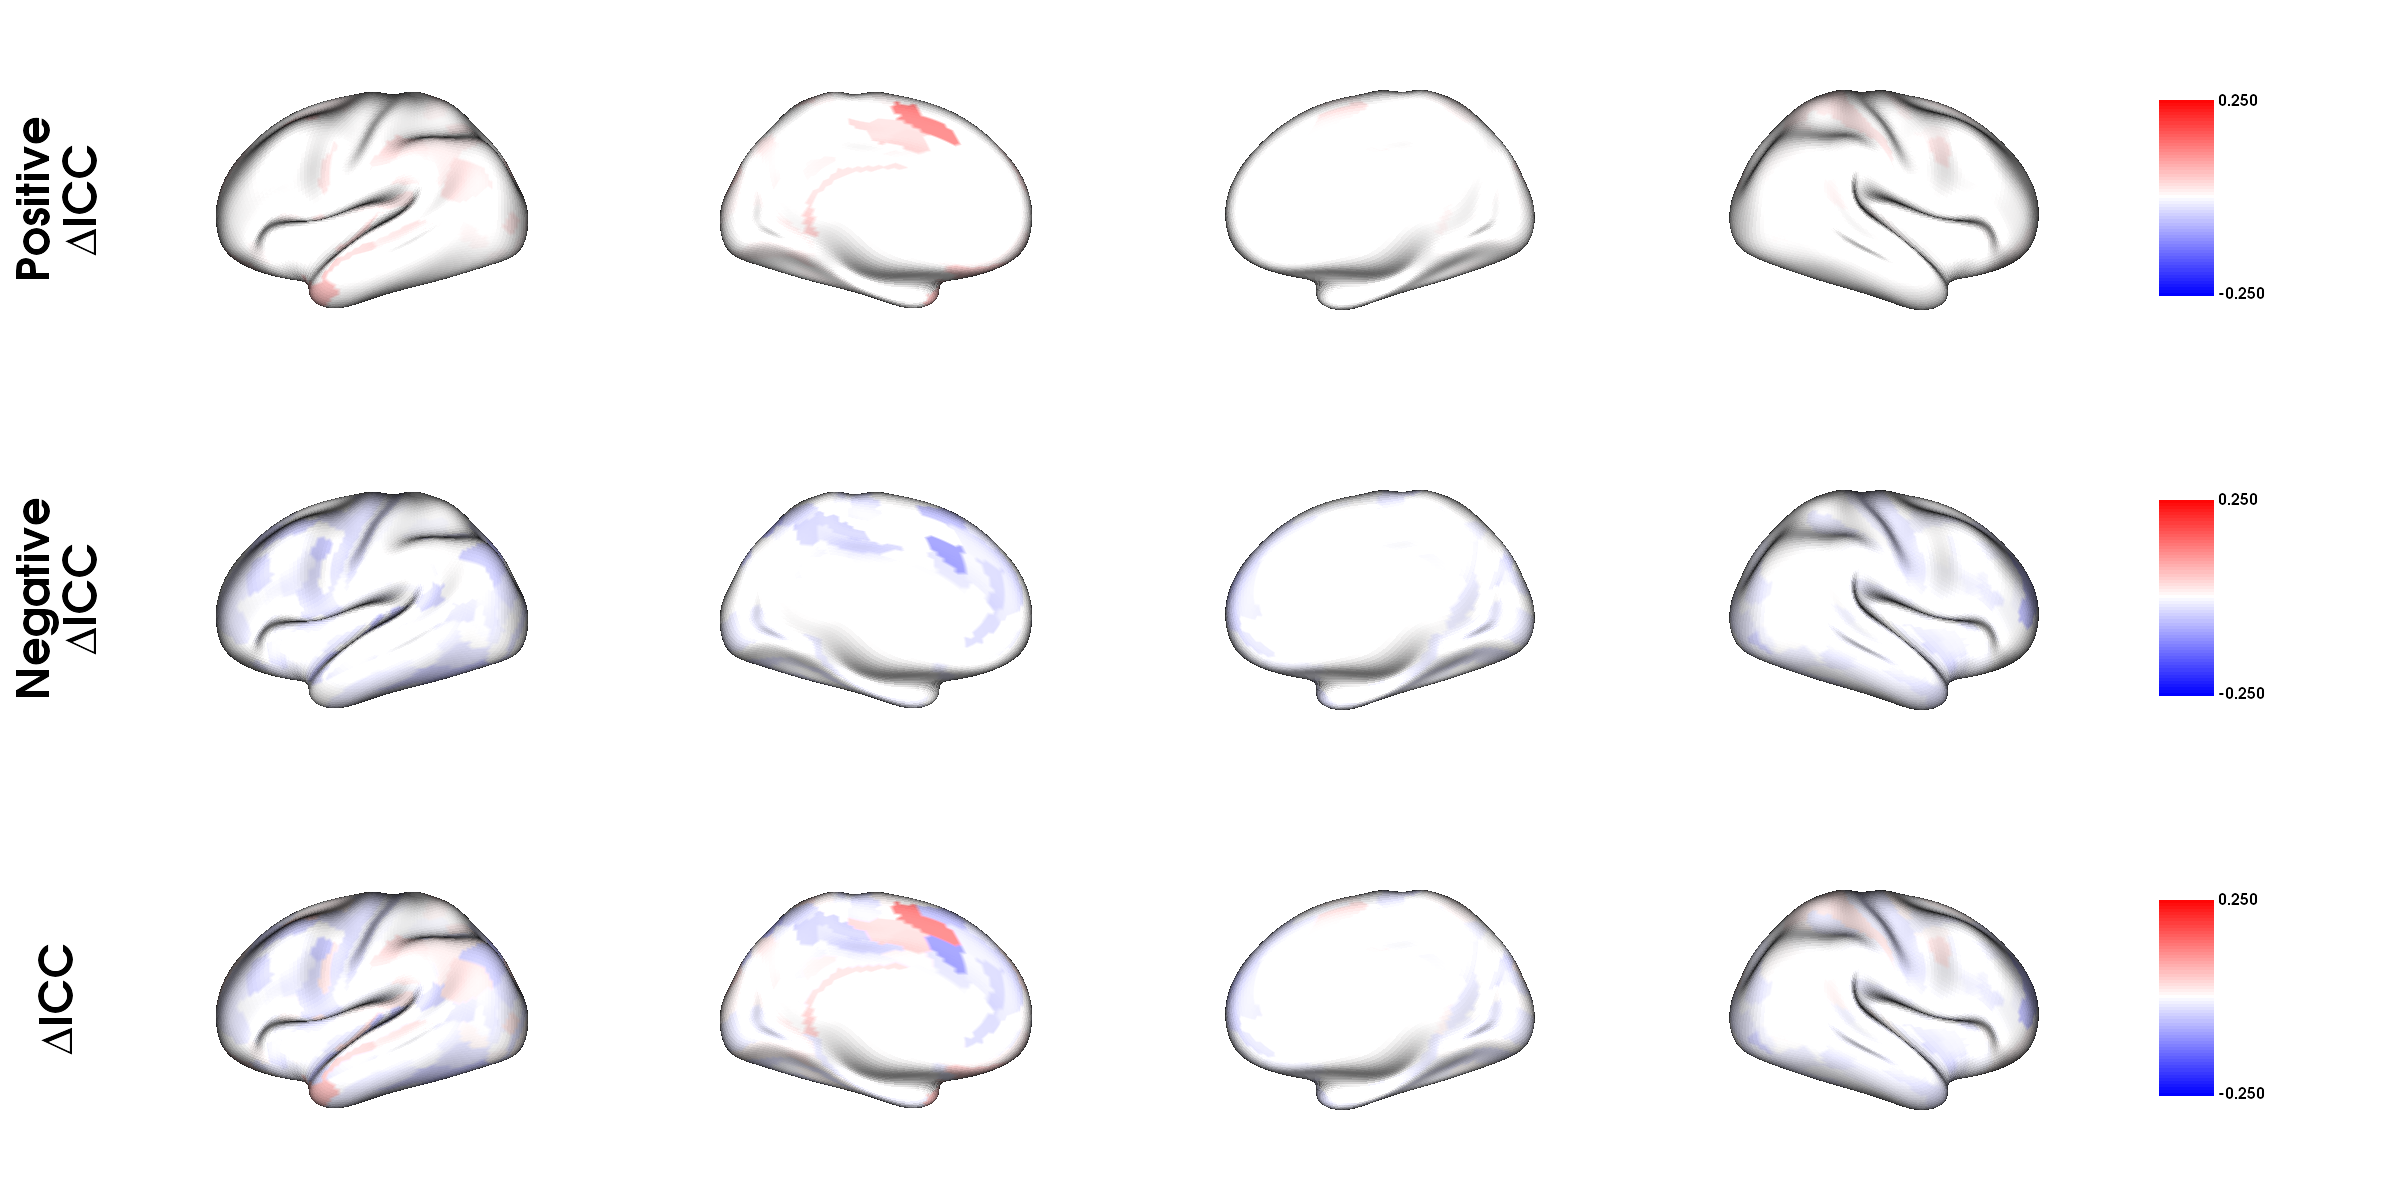

In [22]:
dICCvert = parcel2vert(glasserlabel,df['icc1']-df['icc0'])[0,:]
negMask = dICCvert<0
posMask = dICCvert>0
vertArraysdICC = [dICCvert*posMask,dICCvert*negMask,dICCvert]
plot_hemispheres(lsurf, rsurf, array_name=vertArraysdICC, size=(2400, 1200), 
                 cmap=['bwr','bwr','bwr'],
                color_bar=True,interactive=False,embed_nb=True,nan_color=(1,1,1,1),
                 color_range=(-0.25,0.25),label_text=[u'Positive\nΔICC',u'Negative\nΔICC','ΔICC'],
                 transparent_bg=True,mapper__interpolateScalarsBeforeMapping=False)